## MATH50003 Week 2 Notes

In [1]:
using ColorBitstring, Plots

### Error in approximating the derivative using finite differences
$|f'(x)-\frac{f(x+h) - f(x)}{h}|\leq \frac{M}{2}h$ where $M = sup_{x \leq t \leq x+h}|f''(t)|$

### Convergence of finite differnce
Define $h = a^{-n}$ where a is normally a natural number, and $S$ is the number of siginficand bits (for Float64, S=52; Float32: S=23; Float16: S=10). 

Then,

for $0 \leq n \leq \frac{S}{2}$, the approximation converges.

for $\frac{S}{2} < n \leq S$, the approximation is exact.

for $S \leq n$, the approximation breaks down.

### Example

Consider differentiating two polynomials $f(x)=1+x+x^2$ and $g(x)=1+\frac{x}{3}+x^2$ at $x=0$. 

The following picture shows how fast the approximation converges to the true value of derivatives. f(x) is a very special case. Most polynomials act as g(x), the approximation starts to converge, but then diverges exponentially fast, before levelling off!

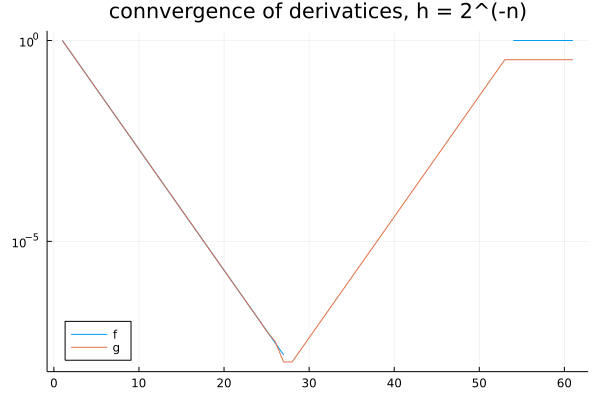

In [6]:
f = x -> 1 + x + x^2
g = x -> 1 + x/3 + x^2
h = 2.0 .^ (0:-1:-60) # [1, 1/2, 1/4]
nanabs = x -> iszero(x) ? NaN : abs(x) #avoid 0's in log scale plot 
plot(nanabs.((f.(h) .- f(0)) ./ h .- 1); yscale=:log10, title="connvergence of derivatices, h = 2^(-n)", label="f", legend=:bottomleft)
plot!(abs.((g.(h) .- g(0)) ./ h .- 1/3); yscale=:log10, label="g")

### Implementation of Dual Number as a special type

In [55]:
# Dual(a,b) represents a + bϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0ϵ
Dual(a::Real) = Dual(a, zero(a))

# Allow for a + bϵ syntax
const ϵ = Dual(0,1)

import Base: +, -, *, /, ^, zero, exp, cos, sin, one

# Support Polynomials addition/subtraction/mulpication with a real number
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# Support dual number divides by a real number
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# Support dual number * real number
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not Implement")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# Support Identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

#Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a+y.a, x.b+y.b)
-(x::Dual, y::Dual) = Dual(x.a-y.a, x.b-y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b+x.b*y.a)

#Exponent
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

# Suport trigometry
function cos(x::Dual)
    Dual(cos(x.a), -sin(x.a)*x.b)
end

function sin(x::Dual)
    Dual(sin(x.a), cos(x.a)*x.b)
end

#Support division between two dual numbers
function /(x::Dual, y::Dual)
    if iszero(y.a)
        error("Real part of denominator is zero.")
    end
    Dual(x.a / y.a, (y.a * x.b - x.a * y.b) / (y.a^2))
end

/ (generic function with 136 methods)

### Differentiation of dual numbers

Suppose a real-valued function f is differetiable at a. 

If $f(a+b\epsilon)=f(a)+bf'(a)\epsilon$, then it is a dual extension at a, and the dual part is the derivative of f at point a (with the choice of b to be 1, naturally).

Notice the chain rule and quotient rule are embedded.

### Example

In [13]:
f = x -> 1 + 1.3x + 2.1x^2 + 3.1x^3
f(0.5 + ϵ).b - 5.725 # We know the derivative of f at x = 0.5 is 5.725, and we can see it is indeed roughly accurate.

8.881784197001252e-16

In [16]:
# Example of polynomial 1 + ... + xⁿ
function s(n, x)
    ret = 1 + x
    for k = 2:n
        ret += x^k
    end
    ret
end
s(10, 0.1 + ϵ).b #Derivative of 1 + x + ... + x^10 at x = 0.1

1.2345678999999998

### Computational cost

Consider the double sum $\sum^{n}_{k=1}\sum^{k}_{j=1}x^2_j$, the implementation is as follow.

In the inner loop, the number of CPU operations per step is 2 due to the addition and multiplication. Thus the total number of CPU operations is 2n. But the constant is misleading, so we just say the computational cost of the inner loop is $\mathcal{O}(n)$.

And the outer loop performs n times inner loop, so as $n -> \infty$, we say the computational cost of this function is $\mathcal{O}(n^2)$.

In [20]:
function twosumsq(x)
    n = length(x)
    ret = 0.0
    for k = 1:n
        for j = 1:k 
            ret += x[j]^2
        end
    end
    ret
end

n = 100
x = randn(n) # Create a list consisting 100 real numbers
twosumsq(x)

7006.62527554429

### Question of differentiation

First, Implement the central differences $f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$.

Then implement central diiferences for $f(x)=1+x+x^2$ and $g(x)=1+\frac{x}{3}+x^2$. Plot the errors for h = 2.0 .^ (0:-1:-60) and h = 10.0 .^ (0:-1:-16) respectively.

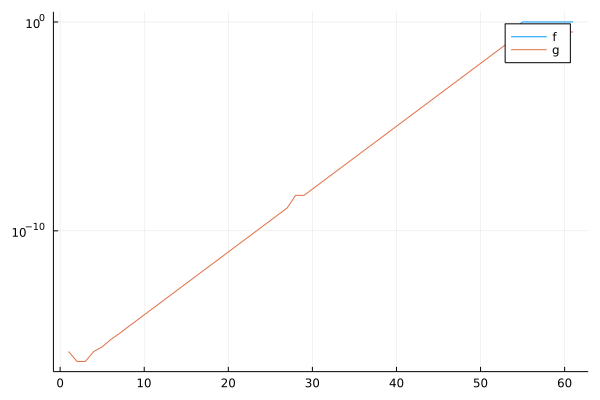

In [6]:
f = x -> 1 + x + x^2
fp = x -> 1 + 2x

g = x -> 1 + x/3 + x^2
gp = x -> 1/3 + 2x

h = 2.0 .^ (0:-1:-60)

centraldiff(x, h, f) = (f(x+h) - f(x-h)) / (2h)
centraldifferror(x, h ,f, fp) = abs(centraldiff(x, h, f) - fp(x))

x = 0.0

nanabs(x) = iszero(x) ? NaN : abs(x)

plot(nanabs.(centraldifferror.(x, h, f, fp)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, gp)), yaxis=:log10, label="g")

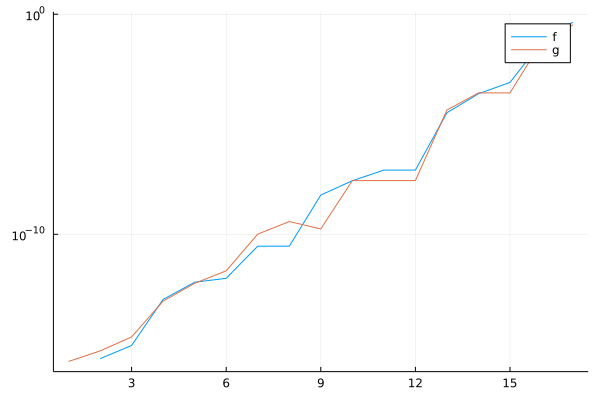

In [7]:
h1 = 10.0 .^ (0:-1:-16)
plot(nanabs.(centraldifferror.(x, h1, f, fp)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h1, g, gp)), yaxis=:log10, label="g")


Now implement the second-order derivative approximation $f''(x) \approx \frac{f(x+h)-2f(x)+f(x-h)}{h^2}$.

Use finite-differences, central differences, and second-order fininte-differences to approximate to 5-digits the first and second derivatice to the following functions at the point x = 0.1:
$$
\prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + \ddots}}},
$$
e.g.:
$$
\begin{align*}
f^{\rm s}_1(x) &= 1 + {x-1 \over 2} \\
f^{\rm s}_2(x) &= 1 + {x-1 \over 2 + {x -1 \over 2}} \\
f^{\rm s}_3(x) &= 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}
\end{align*}
$$

In [8]:
forwarddiff(x, h, f) = (f(x+h)-f(x)) / h
finitediffsecond(x, h, f) = (f(x+h) - 2f(x) + f(x-h)) / (h^2)

f = x -> prod([x] ./ (1:1000) .- 1)
function cont(n, x)
    ret = 2*one(x)
    for k = 1:n-1
        ret = 2 + (x-1) / ret
    end
    1 + (x-1)/ret
end

x = 0.1 #Define arbitrary point
h = eps(); # Define h by machine epsilon

In [9]:
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), f)) # sqrt: x^1/2
println("f'($x) with central difference: ", centraldiff(x, cbrt(h), f)) # cbrt: x^1/3
println("f''($x) via finite difference:  ", finitediffsecond(x, cbrt(h),f))

f'(0.1) with forward difference: -3.5938263945281506
f'(0.1) with central difference: -3.5938265143048937
f''(0.1) via finite difference:  26.638555736977985


In [50]:
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), x->cont(1000,x)))
println("f'($x) with central difference: ", centraldiff(x, sqrt(h), x->cont(1000,x)))
println("f''($x) via finite difference:  ", finitediffsecond(x, cbrt(h), x->cont(1000,x)))

f'(0.1) with forward difference: 1.5811387598514557
f'(0.1) with central difference: 1.5811388231813908
f''(0.1) via finite difference:  -7.905698560322122


### Question of Dual Numbers

Newton iteration is an algorithm for computed roots of a function $f$ using its derivative: given an initial guess $x_0$, one
obtains a sequence of guesses via
$$
x_{k+1} = x_k - {f(x_k) \over f'(x_k)}
$$

Use `Dual` to implement the following function which returns $x_n$:

In [56]:
function newton(f, x0, n)
    xk= x0
    for k = 1:n
        fd = f(xk + ϵ)
        xk = xk - fd.a / fd.b # Dual part of the function is the derivative
    end
    xk
end

newton (generic function with 1 method)

Compute points $y$ such that $|f(y)| \leq 10^{-13}$ (i.e., approximate roots):
$$
\exp(\exp x \cos x + \sin x)-6\hbox{ and } \prod_{k=1}^{1000} \left({x \over k}-1\right) - {1 \over 2}
$$
(Hint: you may need to try different `x0` and `n` to get convergence. Plotting the function should give an
indication of a good initial guess.)

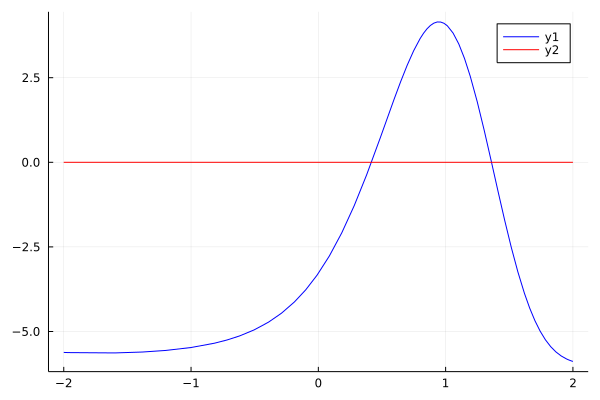

In [57]:
#Plot the functions
f1(x) = exp(exp(x)cos(x)+sin(x)) - 6
f2(x) = prod([x] ./ range(1, 1000) .- 1) - 1/2

plot(f1, -2, 2, color = "blue") # Choose the initial point for f1 to be 1.5
plot!(x->0, color = "red")

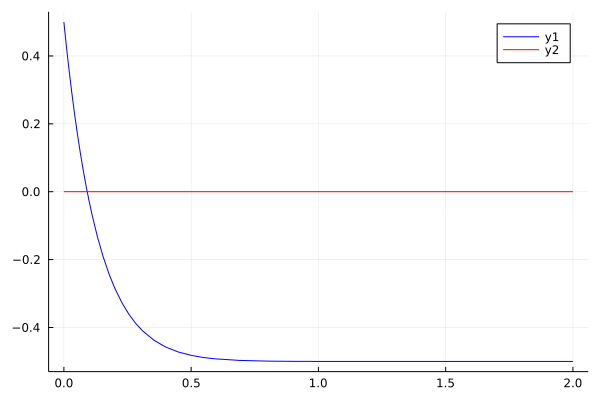

In [58]:
plot(f2, 0, 2, color = "blue") # Choose the initial point for f2 to be 0.1
plot!(x->0, color = "red")

In [59]:
rootf1 = newton(f1, 1.5, 5)
f1(rootf1) # Indeed a root

0.0

In [62]:
rootf2 = newton(f2, 0.1, 20)
f2(rootf2) # Roughly a root

-5.551115123125783e-16